In [1]:
using Compat, Random, Distributions, Plots, LinearAlgebra, Statistics
gr(fmt=:png)
e = 2.7182818284
Random.seed!(1);

Suppose there is a worker who is engaged in a long-term relationship with a firm.
The state of the relationship at time $t$ may be summarized by the worker's professional standing $s_t$.
Her income at each period is $ws_t$
Each period, she invests labor $l_t$ into her career.
The state evolves as

$$
s_{t+1} = l_t + (1-\delta)s_t
$$

Assume the worker just consumes all her income.
Her problem can be written recursively:

$$
V(s) = \underset{s',l\in[0,1]}{\max} \Big[ u(ws) - h(l) + \beta V(s') \Big]
$$

Replacing the control,

$$
V(s) = \underset{s'\in[(1-\delta)s,(1-\delta)s+1]}{\max} \Big[ u(ws) - h(s'-(1-\delta)s) + \beta V(s') \Big]
$$

The highest possible $s$ she can maintain is $1/\delta$.
We will take that into account when making a grid.

In [2]:
N = 1000
v = zeros(N)
s = zeros(N)
V = zeros(N)
S = Array{Int64}(undef, N)
n = zeros(N)
delta = 0.05
beta = 0.98
w = 1
theta = 0.5
a = 2
psi = 10
s_max = 1/delta/2
id = Matrix{Float64}(I,N,N)
Theta = Matrix{Float64}(I,N,N)
G = Matrix{Float64}(I,N,N);

It is convenient to define the period return function $G(s,s')$:

$$
G(s,s') = u(ws) - h(s' - (1-\delta)s)
$$

The Bellman equation now becomes 

$$
V(s) = \underset{s'\in[(1-\delta)s,(1-\delta)s+1]}{\max} \Big[ G(s,s') + \beta V(s') \Big]
$$

In [3]:
#functions

function u(c)
    return c^(1-theta)/(1-theta)
end

function h(l)
    return psi*l^a
end

function ret(x,y)
    return u(w*x) - h(y-(1-delta)*x)
    end;

The function $G(\cdot)$ may be represented by an $N\times N$ array, since we are discretizing the state space.
It is better (faster) to use an array then to call a function every time you need to evaluate it. 

In [4]:
#fill the state vector and matrices

for i in 1:1:N
    s[i] = i/N*s_max
    n[i] = i
end
for i in 1:1:N
    for j in 1:1:N
        G[i,j] = ret(s[i],s[j])
    end
end

Now we will iterate the value function.
The idea of the algorithm is the following:

1. Guess a value function and put it into the right-hand side
2. Treating your guess as a known function, solve the Bellman equation for all $s$
3. Update the guess with your solution
4. Iterate until convergence

We discretized the state space, so value function is a vector of the length $N$.
Suppose you have a guess $V_n(\cdot)$.
Determine $V_{n+1}(\cdot)$ from the "Bellman equation":

$$
V_{n+1}(s) = \underset{s'\text{ from the grid}}{\max}\Big[ G(s,s') + \beta V_n(s')\Big]
$$

This is easily done with a loop.
After you have your new guess, check the distance between it and the old one:

$$
d = ||V_n(\cdot)-V_{n+1}(\cdot)||_\infty
$$

If your code is correct, it should shrink as you repeat the procedure.
Iterate until it is sufficiently small (take into account execution time to decide what it means):

In [5]:
#value function iteration

V = zeros(N)
for i in 1:1:N
    V[i] = G[i,i]/(1-beta)
end

m = 0
dist = 1000
count = 0

while (dist>0.1) & (count < 1000)
    count = count + 1
    for i in 1:1:N
        m = G[i,1] + beta*V[1]
        S[i] = 1
        for j in 2:1:N
            if m <= G[i,j] + beta*V[j]
                m = G[i,j] + beta*V[j]
                S[i] = j
            end
        end
        v[i] = m
    end
    dist = mean((v-V).*(v-V))*N
    V = deepcopy(v)
    print(dist," ")
end
print("\n\n distance = ",dist,"\n iteration count = ",count)

276706.4015270061 36102.53611961146 13118.41763369249 6016.009173854131 3119.5398531298056 1749.277347541921 1036.0032615495609 638.8544802165175 406.30984296800204 264.7743068921443 175.92650920600778 118.76796755190017 81.24001459325426 56.16737093014707 39.19598547024977 27.56161851099827 19.511326263386497 13.889469434302493 9.934974086881796 7.136227198788243 5.143968380630542 3.7210585699811287 2.6974611666053763 1.9604487864982911 1.428386633433324 1.041797155651975 0.7614765738808846 0.5579510056473523 0.40850163501397757 0.29928021997226983 0.21989861777597847 0.16146030783252593 0.11902259448427732 0.08725026358719642 

 distance = 0.08725026358719642
 iteration count = 34

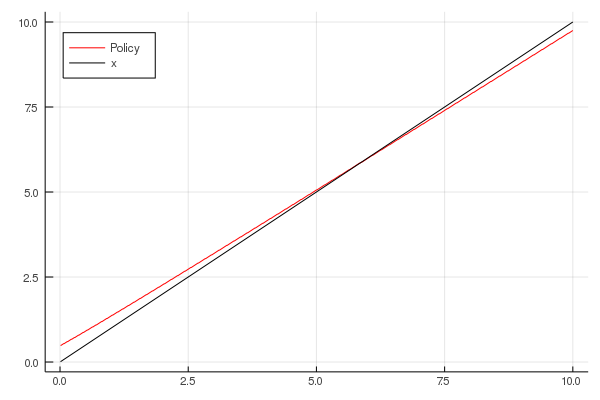

In [6]:
#plot the policy function

plot(n/N*s_max,S/N*s_max,color=:red,label="Policy",legend=:topleft)
plot!(n/N*s_max,n/N*s_max,color=:black,label="x")

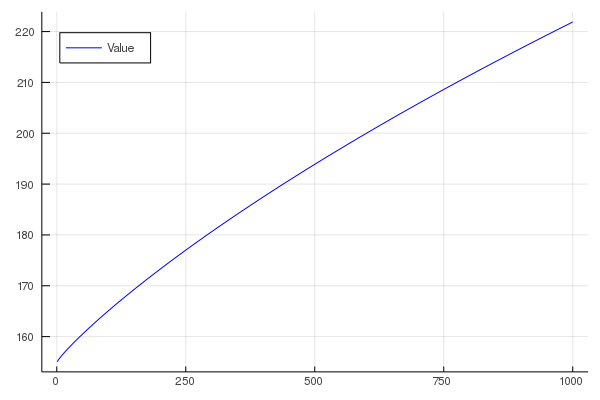

In [7]:
#plot the value function

plot(n,V,color=:blue,label="Value",legend=:topleft)

Another (and often better) way to do it is to iterate on the policy function.
The general principle is the same:

1. Get a hold of a guess
2. Compute something
3. Update the guess
4. Iterate until convergence

We still have a guess $V_n(\cdot)$, but now the importnant thing is the policy $g_n(\cdot)$.
It is computed as usually:

$$
g_n(s) = \underset{s'\text{ from the grid}}{\text{arg }\max} \Big[G(s,s') + \beta V_n(s')\Big]
$$

The next value function guess is recovered from this policy function.
Pretend that this policy function solves some Bellman equation and take the implied value function:

$$
V_{n+1}(s) = G(s,g_n(s)) + \beta V_{n+1}(g_n(s))
$$

Since we discretize the state space, $g_n(\cdot)$ is just a vector, as is $G(s,g_n(s))$.
The object $V_{n+1}(g_n(s))$ is easily recovered from $V_{n+1}(\cdot)$ by picking the required component of this vector for each $s$.
This is achieved by taking a matrix $\Theta$ and multiplying it by $V_{n+1}(\cdot)$:

$$
V_{n+1}(\cdot) =  G(\cdot,g_n(\cdot)) + \beta\Theta V_{n+1}(\cdot)
$$

The matrix $\Theta$ picks the required component, so every row has $1$ in the right place and $0$ everywhere else.
The right place is determined by $g_n(\cdot)$.
Rearranging,

$$
(1-\beta\Theta)V_{n+1}(\cdot) = G(\cdot,g_n(\cdot))
$$

Now you have to invert a matrix.
This procedure becomes slower as $\beta\rightarrow 1$, so policy function iteration is less effective for weaker discounting.
The formula for the new guess is

$$
V_{n+1}(\cdot) = (1-\beta\Theta)^{-1} G(\cdot,g_n(\cdot))
$$

In [8]:
#policy function iteration

V = zeros(N)
#for i in 1:1:N
#    V[i] = G[i,i]/(1-beta)
#end
S_p = zeros(N)
m = 0
dist = 1000
count = 0

while (dist>1) & (count < 100)
    count = count + 1
    for i in 1:1:N
        m = G[i,1] + beta*V[1]
        S[i] = 1
        for j in 2:1:N
            if m < G[i,j] + beta*V[j]
                m = G[i,j] + beta*V[j]
                S[i] = j
            end
        end
        Theta[i,:] = zeros(N)
        Theta[i,S[i]] = 1
        g[i] = G[i,S[i]]
    end
#    print(S)
    V = deepcopy(inv(id-beta*Theta)*g)
    dist = mean((S_p-S).*(S_p-S))*N
    S_p = deepcopy(S)
    print(dist," ")
end
print("\n\n distance = ",dist,"\n iteration count = ",count)

UndefVarError: UndefVarError: g not defined

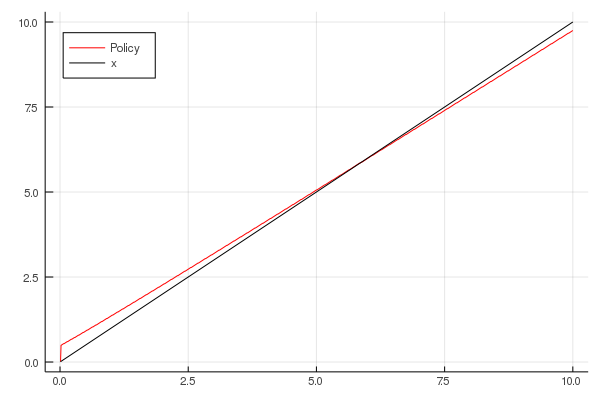

In [9]:
#plot the policy function

plot(n/N*s_max,S/N*s_max,color=:red,label="Policy",legend=:topleft)
plot!(n/N*s_max,n/N*s_max,color=:black,label="x")

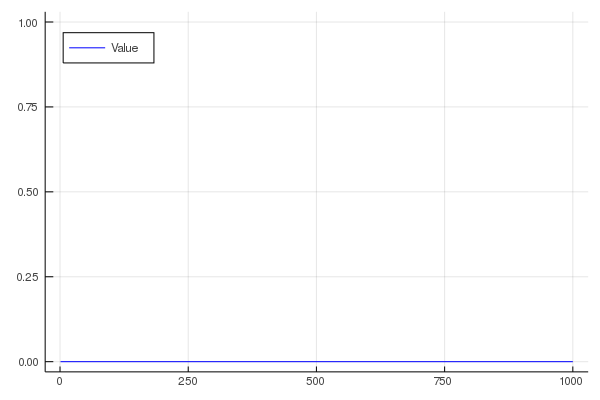

In [10]:
#plot the value function

plot(n,V,color=:blue,label="Value",legend=:topleft)